# Numenta Anomaly Benchmark

### Description

The datasets used in this notebook were gathered from the Kaggle datset: <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab> Numenta Anomaly Benchmark (NAB)</a>. Each subfolder contains a timeseries-like dataset of real world/artificial anomaly observations.

The full description of each dataset can be found <a href=https://www.kaggle.com/datasets/boltzmannbrain/nab>here</a>.


### Purpose
The purpose of this notebook is to showcase various data processing and estimating techniques based on the NAB dataset. Timeseries forecasting and anomaly detection are closely related fields, both having enormous impact in the fields of finance and engineering.


### To-Do

- [ ] Figure out LSTM Autoencoder
- [ ] Optimize Markov Process (takes too long)
- [ ] Aggregate 9 other ticker inf. (change FILENAME for now)


---

## Table of contents
1. [Dataset](#1.0)
2. [Data Preparation](#2.0)
3. [Methods](#3.0)
   
      3.1 [Kmeans](#3.1)

      3.2 [LSTM Autoencoder](#3.2)

      3.3 [Markov](#3.3)

      3.4 [DBSCAN](#3.4)
      
      3.5 [Isolation Forest](#3.5)

4. [Comparison](#4.0)
5. [Correlation to hist data](#5.0)
6. [Sources](#6.0)

#### But what is an anomaly?

According to this <a href=https://towardsdatascience.com/effective-approaches-for-time-series-anomaly-detection-9485b40077f1>Towards Data Science article: </a>

> " ...a data point which is not following the common collective trend or seasonal or cyclic pattern of the entire data and is significantly distinct from rest of the data."

The 3 main approaches we can use to detect time-series anomalies are based on:

    1. Statistical estimation
    2. Unsupervised clustering
    3. ML algorithms

<a id="1.0"></a>

## 1. Dataset

#### 1.1 Visualization 


Since there are many data files with different patterns lets visualize a few of them.

For this notebook, I chose a real dataset from Twitter.
The dataset has time-series data, with the only dimension: tweets mentioning the company ticker in focus. 
Timesteps are approximately every 5 minutes.


In [438]:
import os
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics import tsaplots
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from matplotlib.pyplot import style
from sklearn.cluster import KMeans
from pyemma import msm
from sklearn.cluster import DBSCAN
import tensorflow as tf
import seaborn as sns
import yfinance as yf
from scipy import stats

style.use("seaborn-v0_8-dark")

In [439]:
NO_OF_PLOTS_SHOWN = 4 # Number of graphs shown in the EDA part, set to low for easy readability

In [440]:
def plot_csv(path,nrows,ncols):
    fig,axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(15,10))
    for i,f in enumerate(os.listdir(path)):
        df= pd.read_csv(path+f)
        if i < ncols:
            ax = axes[0,i]
        else:
            ax = axes[1,i-ncols]
        ax.plot(df["timestamp"], df["value"])
        ax.set_title(f[:-4])
        
        # axes.plot(x ="timestamp", y="value")
        

# path_art_anom = "data//realTweets//realTweets//"
# plot_csv(path_art_anom,2,5)
# df = pd.read_csv("data//artificialWithAnomaly//artificialWithAnomaly//art_daily_jumpsup.csv")

#### Based on the spikes shown on the graphs below and on previous experience, when working with datasets like this, it is more convenient to log transform the variable in question.

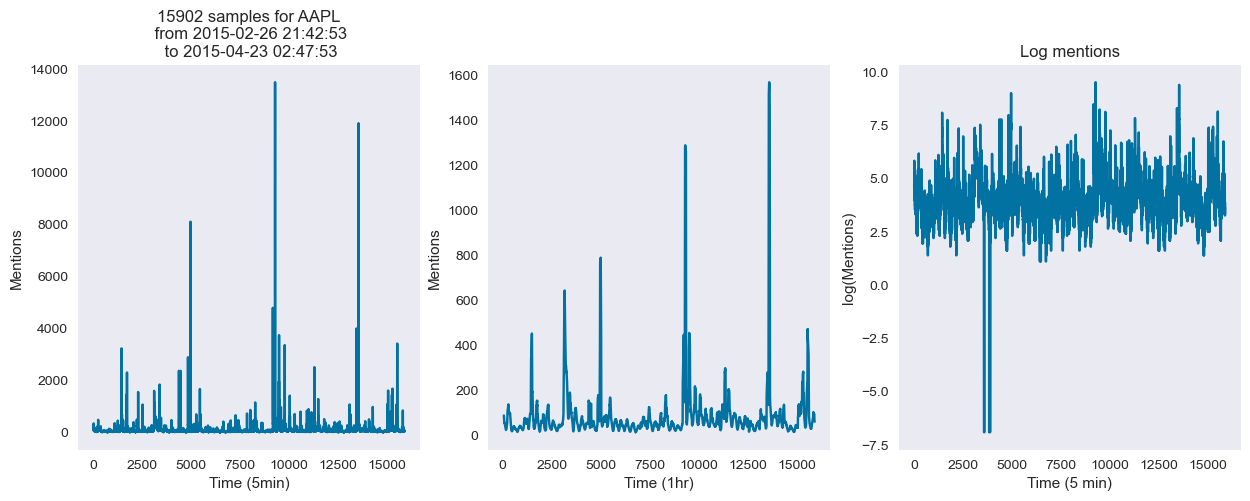

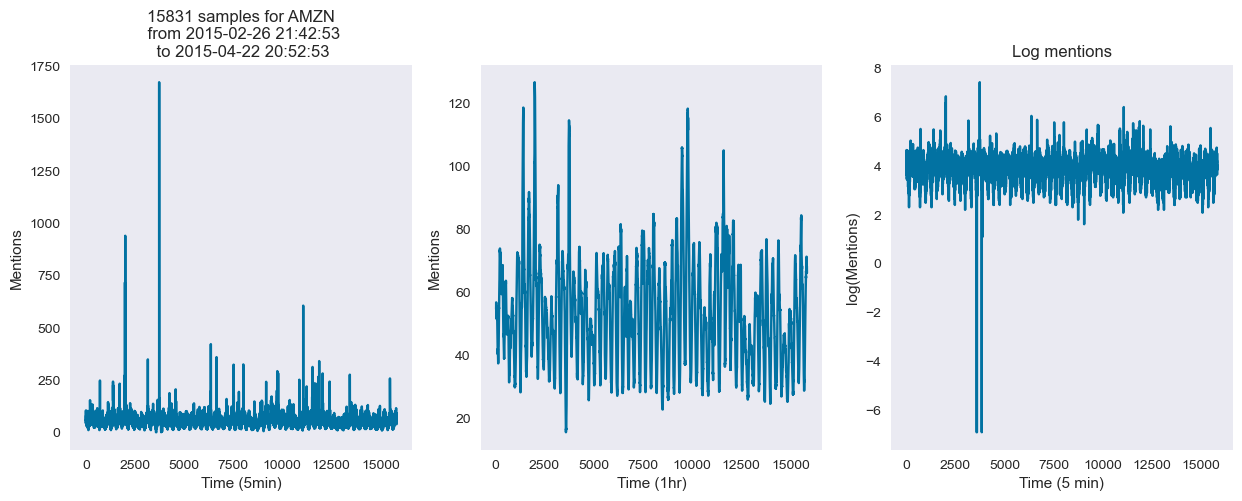

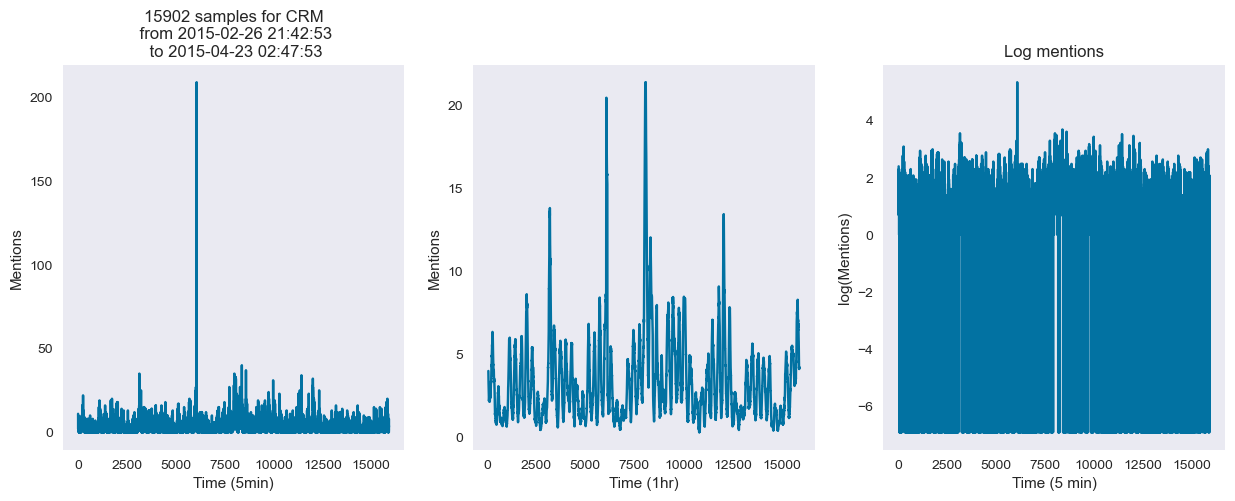

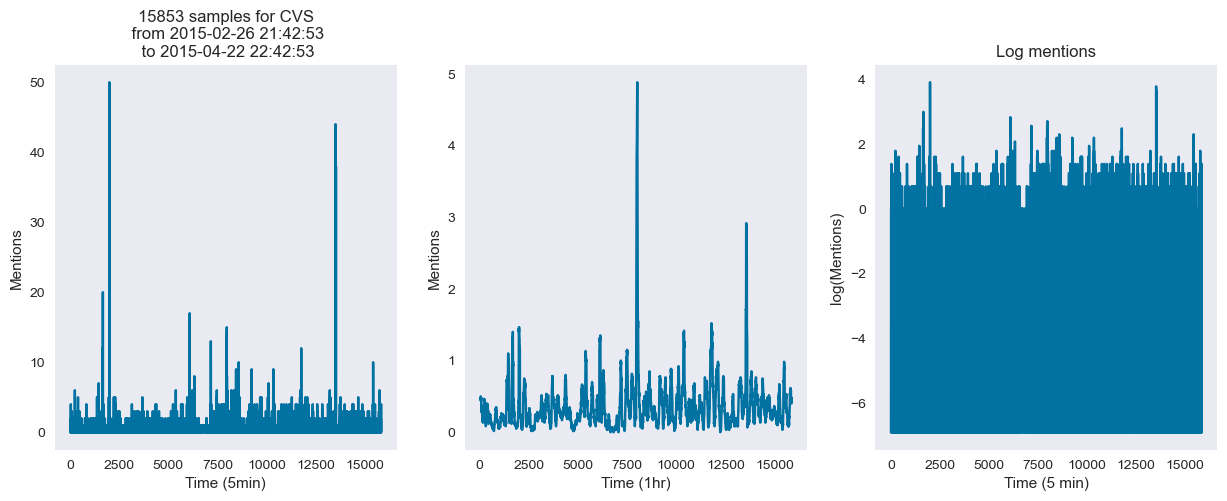

In [441]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,3,figsize=(15,5))
    df = pd.read_csv(path+f)
    print()
    df["hr_avg"] = df['value'].rolling(window=60).mean()
    ax[0].plot(df["value"])
    ax[0].set_title("{} samples for {}\n from {}\n to {}".format(len(df),f.split("_")[2][:-4],min(df.timestamp),max(df.timestamp)))
    ax[0].set_xlabel("Time (5min)")
    ax[0].set_ylabel("Mentions")
    
    ax[1].plot(df["hr_avg"])
    #ax[1].title(f.split("_")[2][:-4])
    ax[1].set_xlabel("Time (1hr)")
    ax[1].set_ylabel("Mentions")
    
    ax[2].plot(np.log(np.abs(df["value"]+0.001)))
    ax[2].set_title("Log mentions")
    ax[2].set_xlabel("Time (5 min)")
    ax[2].set_ylabel("log(Mentions)")
    

<a id="1.2"></a>

#### 1.2 Distribution of data (+Feature extraction)

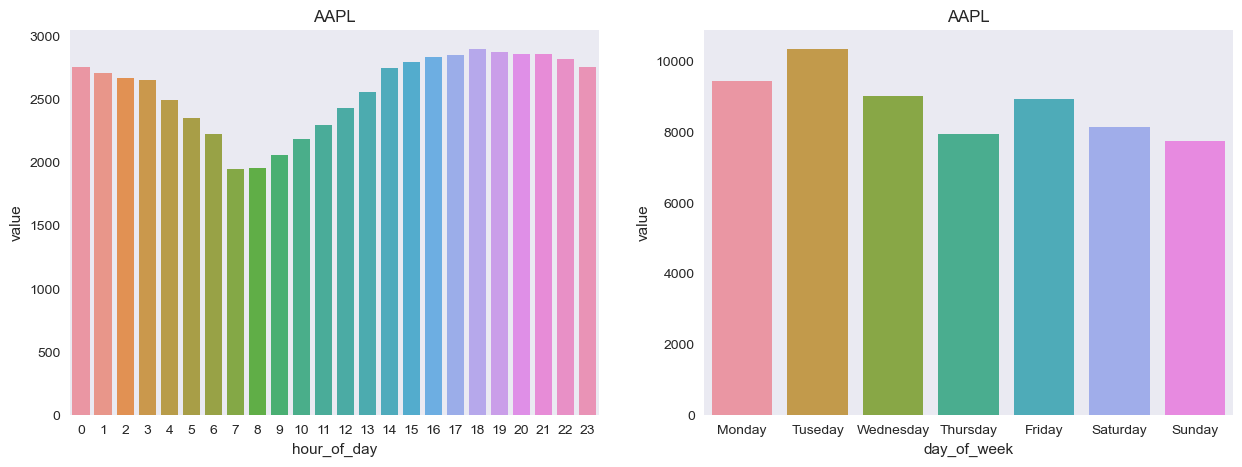

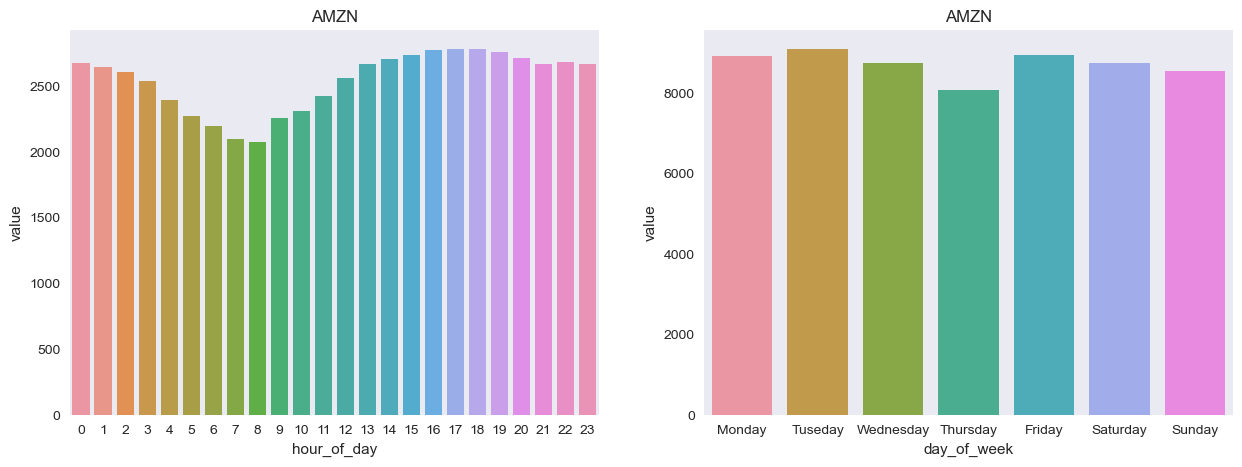

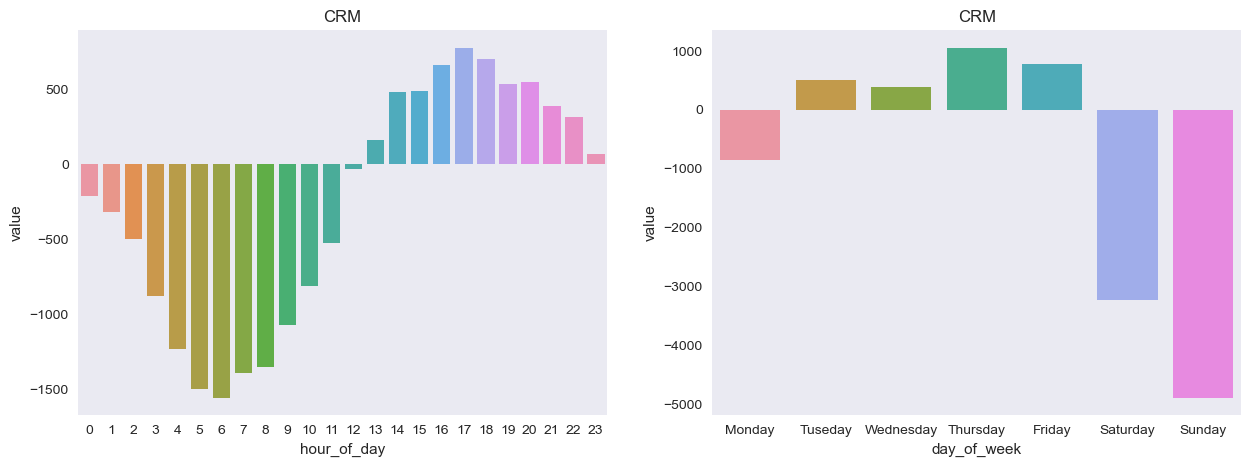

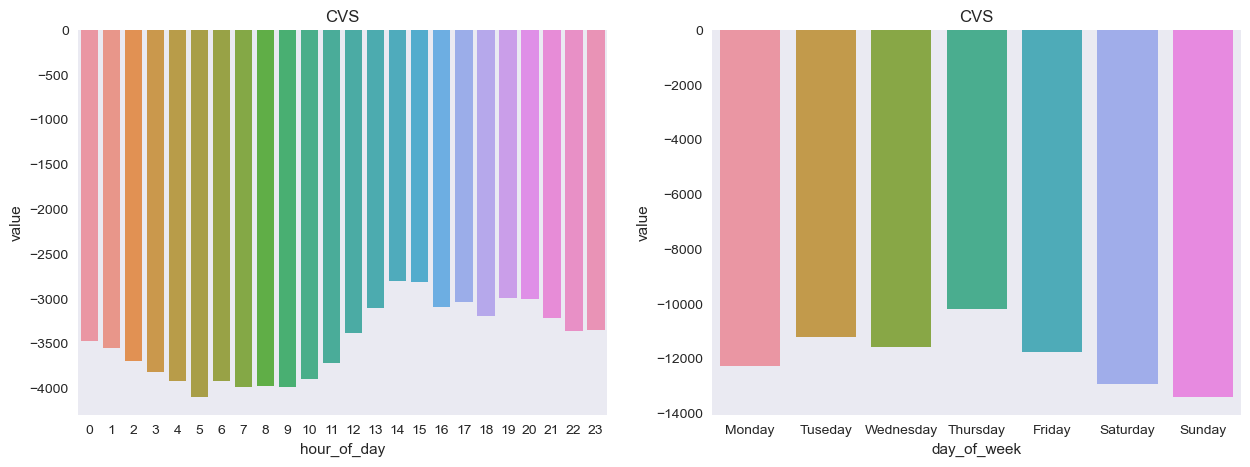

In [442]:
path = "data//realTweets//realTweets//"

for i,f in enumerate(os.listdir(path)[:NO_OF_PLOTS_SHOWN]):
    fig,ax = plt.subplots(1,2,figsize=(15,5))
    df = pd.read_csv(path+f)
    df["value"] = np.log(np.abs(df["value"]+0.001))
    df["timestamp"] = pd.to_datetime(df["timestamp"])
    df["day_of_week"] = df["timestamp"].dt.weekday
    df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
    df["hour_of_day"] = df["timestamp"].dt.hour

    sns.barplot(y = df.groupby(df["hour_of_day"]).sum(numeric_only=True)["value"],x=df.groupby(df["hour_of_day"]).sum(numeric_only=True).index,ax=ax[0])
    sns.barplot(y = df.groupby(df["day_of_week"]).sum(numeric_only=True)["value"],x=df.groupby(df["day_of_week"]).sum(numeric_only=True).index,ax=ax[1])
    ax[1].set_xticklabels(["Monday","Tuseday","Wednesday","Thursday","Friday","Saturday","Sunday"])
    ax[0].set_title(f.split("_")[2][:-4])
    ax[1].set_title(f.split("_")[2][:-4])
    #sns.displot(df["hr_avg"],ax=ax[1])
    

<a id="1.3"></a>

#### 1.3 Outliers

In [443]:
df["z-score"] = stats.zscore(df["value"])

Text(0.5, 0, 'log z-score')

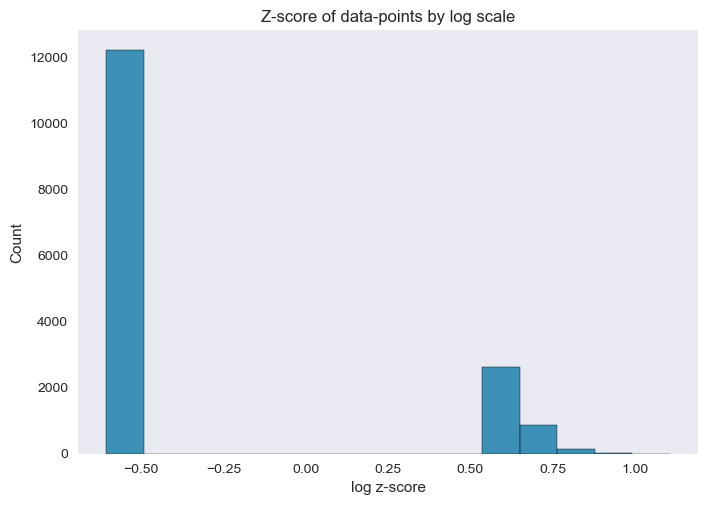

In [444]:
sns.histplot(np.log(np.abs(df["z-score"])))
plt.title("Z-score of data-points by log scale")
plt.xlabel("log z-score")

In [445]:
print("{} data-points with higher z-score than 2".format(len(df[np.abs(df["z-score"]) > 2])))
print("{} data-points with higher z-score than 3".format(len(df[np.abs(df["z-score"]) > 3])))
print("{} data-points with higher z-score than 10".format(len(df[np.abs(df["z-score"]) > 10])))


381 data-points with higher z-score than 2
1 data-points with higher z-score than 3
0 data-points with higher z-score than 10


<a id="1.4"></a>

#### 1.4 Autocorrelation of signals

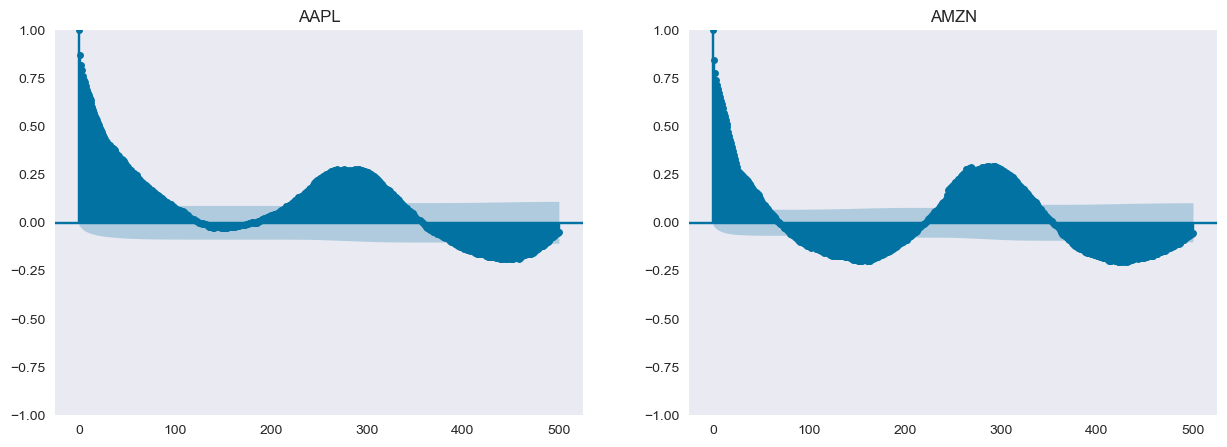

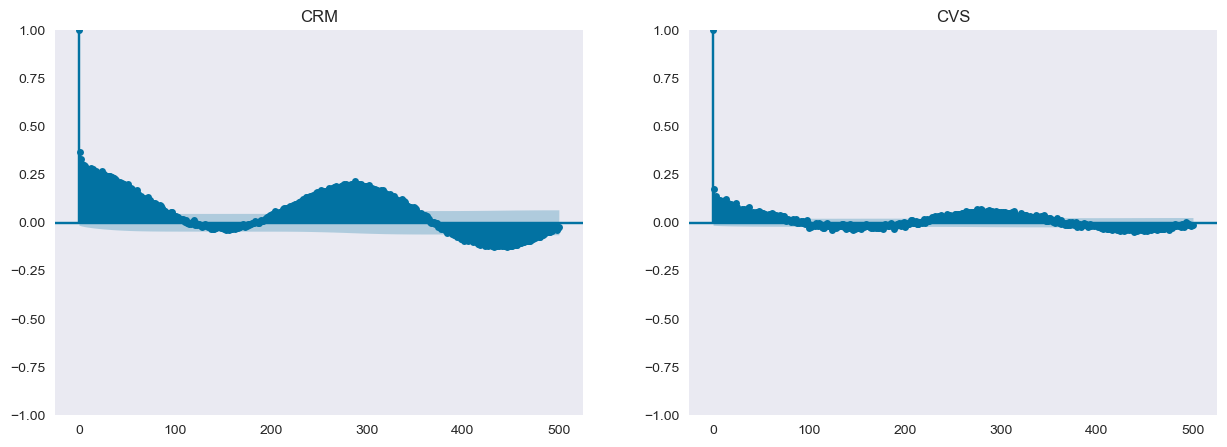

In [446]:
i = 0
for i in range(0,len(os.listdir(path)[:NO_OF_PLOTS_SHOWN])-1,2):
    if i%2 ==0:
        try:
            df1 = pd.read_csv(path+os.listdir(path)[i])
            df2 = pd.read_csv(path+os.listdir(path)[i+1])
            df1["value"] = np.log(np.abs(df1["value"]+0.001))
            df2["value"] = np.log(np.abs(df2["value"]+0.001))
            fig,ax = plt.subplots(1,2,figsize=(15,5))
            
            tsaplots.plot_acf(df1["value"], lags=500,ax=ax[0])
            tsaplots.plot_acf(df2["value"], lags=500,ax=ax[1])
            ax[0].set_title(os.listdir(path)[i].split("_")[2][:-4])
            ax[1].set_title(os.listdir(path)[i+1].split("_")[2][:-4])
            # plt.show()
        except:
            pass
    

<a id="2.0"></a>

## 2. Data Preparation

<a id="2.1"></a>

#### 2.1 Feature Engineering

In [447]:
FILENAME = "Twitter_volume_AAPL.csv"
df = pd.read_csv(path+FILENAME)

#### Let's use log values for data

<AxesSubplot: ylabel='value'>

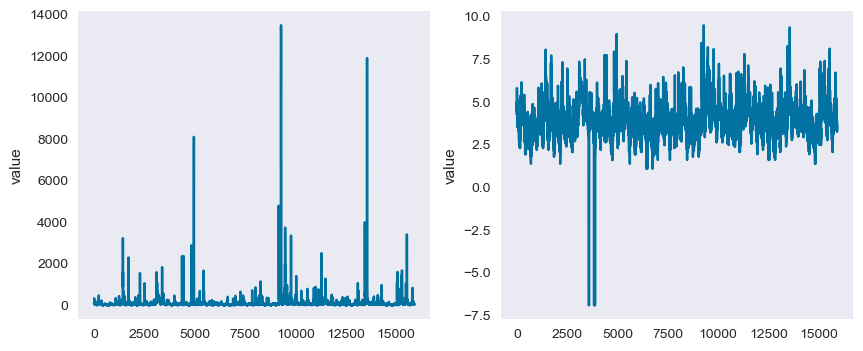

In [448]:
fig,axes = plt.subplots(1,2,figsize=(10,4))
sns.lineplot(df["value"],ax=axes[0])
sns.lineplot(np.log(np.abs(df["value"]+0.001)),ax=axes[1])

In [449]:
df["value"] = np.log(np.abs(df["value"])+0.0001)

In [450]:
df["timestamp"] = pd.to_datetime(df["timestamp"])
df["day_of_week"] = df["timestamp"].dt.weekday
df["week_of_year"] =  df["timestamp"].dt.isocalendar().week
df["hour_of_day"] = df["timestamp"].dt.hour

<a id="2.2"></a>

#### 2.2 Standard Scaling + PCA

In [451]:
st_scaler = StandardScaler()
mm_scaler = StandardScaler()
pca = PCA(n_components=2)
norm_val = mm_scaler.fit_transform(df[["value","day_of_week","week_of_year","hour_of_day"]])
pca_mat = pca.fit_transform(norm_val)
pca_mat = st_scaler.fit_transform(pca_mat)
pca_df = pd.DataFrame(pca_mat,columns=["feature1","feature2"])

<a id="3.0"></a>

## 3. Methods

<a id="3.1"></a>

#### 3.1 Kmeans clustering

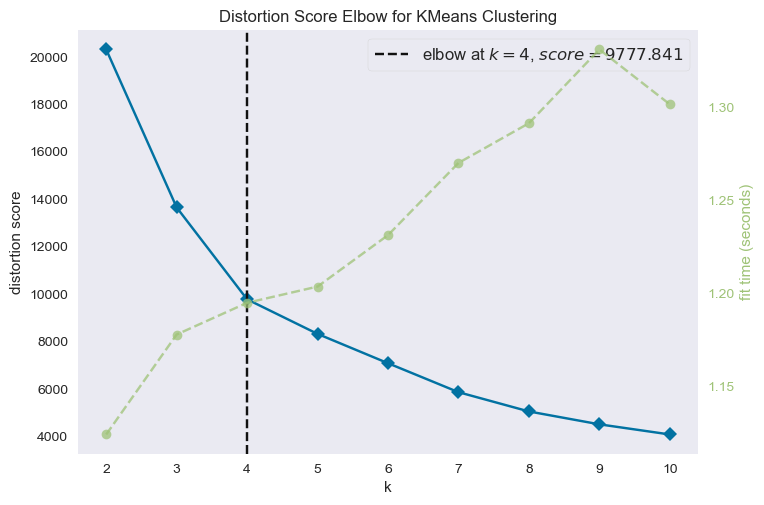

In [452]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(pca_df)
Elbow_M.show();

In [453]:
clf_kmeans = KMeans(n_clusters=4)

pca_df["cluster"] = clf_kmeans.fit_predict(pca_df)

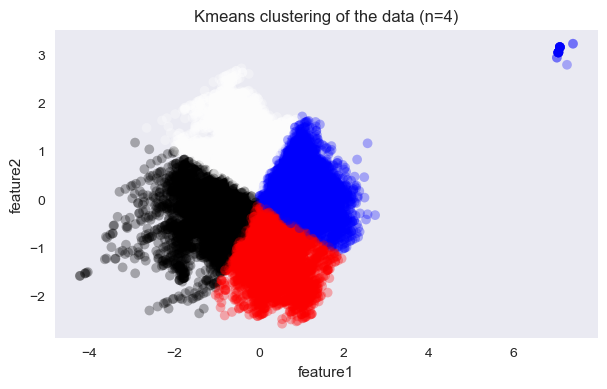

In [454]:
fig= plt.figure(figsize=(7,4))
sns.scatterplot(x=pca_df["feature1"],y=pca_df["feature2"],c=pca_df["cluster"],cmap="flag", alpha=0.3,linewidth=0)
plt.title("Kmeans clustering of the data (n=4)")
plt.show()

In [455]:
def getDistanceByPoint(data, model):
    distance = pd.Series(index=range(len(data)))
    for i in range(0,len(data)):
        Xa = np.array(data.loc[i])
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.at[i] = np.linalg.norm(Xa-Xb)
    return distance 

In [456]:
distance = getDistanceByPoint(pca_df[["feature1","feature2"]], clf_kmeans)
number_of_outliers = int(0.01*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
pca_df['a_dist'] = (distance >= threshold).astype(int)
df['a_dist'] = (distance >= threshold).astype(int)

C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\4182611596.py:2: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  distance = pd.Series(index=range(len(data)))


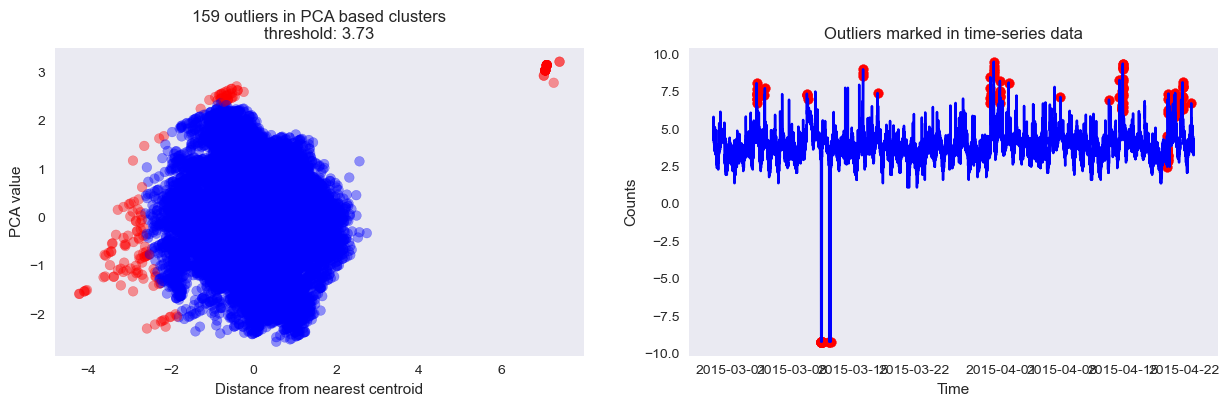

In [457]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

colors = {0:'blue', 1:'red'}
axes[0].scatter(pca_df['feature1'], pca_df['feature2'], c=pca_df["a_dist"].apply(lambda x: colors[x]),alpha=0.4)
axes[0].set_title("{} outliers in PCA based clusters\nthreshold: {:.2f}".format(len(pca_df.loc[pca_df["a_dist"]==1]), threshold))
axes[0].set_xlabel("Distance from nearest centroid")
axes[0].set_ylabel("PCA value")


a = df.loc[pca_df['a_dist'] == 1, ['timestamp', 'value']]
axes[1].plot(df['timestamp'], df['value'], color='blue')
axes[1].scatter(a['timestamp'],a['value'], color='red')
axes[1].set_title("Outliers marked in time-series data")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Counts")

plt.show()

In [458]:
RATIO = 0.8
norm_df = pd.DataFrame(norm_val,columns=["value","day_of_week","week_of_year","hour_of_day"] )
X_train = norm_df[:int(RATIO*len(norm_val))]["value"]
X_test = norm_df[int(RATIO*len(norm_val)):]["value"]

<a id="3.2"></a>

#### 3.2 LSTM Autoencoder 

In [459]:
def autoencoder(X_train):
    inputs = tf.keras.layers.Input(shape=(X_train.shape[0],))
    x = tf.keras.layers.LSTM(16,activation="relu",return_sequences=True)(inputs)
    x = tf.keras.layers.LSTM(4,activation="relu",return_sequences=False)(x)
    x=tf.keras.layers.RepeatVector(X_train.shape[0])(x)
    x = tf.keras.layers.LSTM(4,activation="relu",return_sequences=True)(x)
    x = tf.keras.layers.LSTM(16,activation="relu",return_sequences=True)(x)
    output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1))(x)
    
    model = tf.keras.models.Model(inputs,output)
    
    return model

<a id="3.3"></a>

#### 3.3 Markov Process

In [460]:
def getTransitionMatrix (df):
	df = np.array(df)
	model = msm.estimate_markov_model(df, 1,sparse=True)
	return model.transition_matrix

def markovAnomaly(df, windows_size, threshold):
    transition_matrix = getTransitionMatrix(df)
    real_threshold = threshold**windows_size
    df_anomaly = []
    for j in range(0, len(df)):
        if (j < windows_size):
            df_anomaly.append(0)
        else:
            sequence = df[j-windows_size:j]
            sequence = sequence.reset_index(drop=True)
            df_anomaly.append(sequence)
    return df_anomaly

In [461]:
x1 = (df['value'] <=30).astype(int)
x2= ((df['value'] > 30) & (df['value']<=50)).astype(int)
x3 = ((df['value'] > 50) & (df['value']<=80)).astype(int)
x4 = ((df['value'] > 80) & (df['value']<=120)).astype(int)
x5 = (df['value'] >120).astype(int)

df_mm = x1 + 2*x2 + 3*x3 + 4*x4 +5*x5

In [462]:
# df_anomaly = markovAnomaly(df["value"], 5, 0.20) # ONLY RUN IF YOU GOT A FEW MINS TO SPARE
# df_anomaly = pd.Series(df_anomaly)
# print(df_anomaly.value_counts())

<a id="3.4"></a>

#### 3.4 DBSCAN

In [463]:
min_samples =100
epsilon = 0.5
data = pca_df[["feature1","feature2"]]
dbscan=DBSCAN(min_samples=min_samples,eps=epsilon)
model = dbscan.fit(data)

In [464]:
print(np.unique(model.labels_,return_counts=True))
data["cluster"] = model.labels_
df["a_db"] = model.labels_

(array([-1,  0], dtype=int64), array([   87, 15815], dtype=int64))


C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\3294475043.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["cluster"] = model.labels_


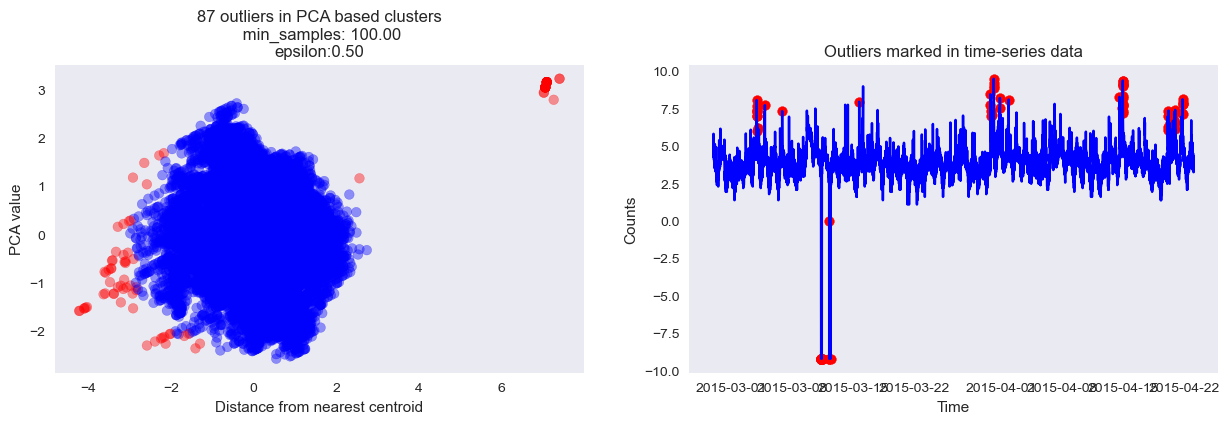

In [465]:
fig, axes = plt.subplots(1,2,figsize=(15,4))

colors = {0:'blue', 1:'red',-1:'red'}
axes[0].scatter(data['feature1'], data['feature2'], c=data["cluster"].apply(lambda x: colors[x]),alpha=0.4)
axes[0].set_title("{} outliers in PCA based clusters\n min_samples: {:.2f}\nepsilon:{:.2f}".format(len(data.loc[data["cluster"]!= 0]), min_samples,epsilon))
axes[0].set_xlabel("Distance from nearest centroid")
axes[0].set_ylabel("PCA value")


a = df.loc[data['cluster'] != 0, ['timestamp', 'value']]
axes[1].plot(df['timestamp'], df['value'], color='blue')
axes[1].scatter(a['timestamp'],a['value'], color='red')
axes[1].set_title("Outliers marked in time-series data")
axes[1].set_xlabel("Time")
axes[1].set_ylabel("Counts")

plt.show()

<a id="3.5"></a>

#### 3.5 Isolation Forest

In [466]:
data = df[['value', "day_of_week","week_of_year","hour_of_day"]]

data = pd.DataFrame(norm_val)
# train isolation forest 
model =  IsolationForest(contamination = 0.01)
model.fit(data)
# add the data to the main  
df['a_if'] = pd.Series(model.predict(data))
df['a_if'] = df['a_if'].map( {1: 0, -1: 1} )
print(df['a_if'].value_counts())

0    15742
1      160
Name: a_if, dtype: int64


Text(0, 0.5, 'Counts')

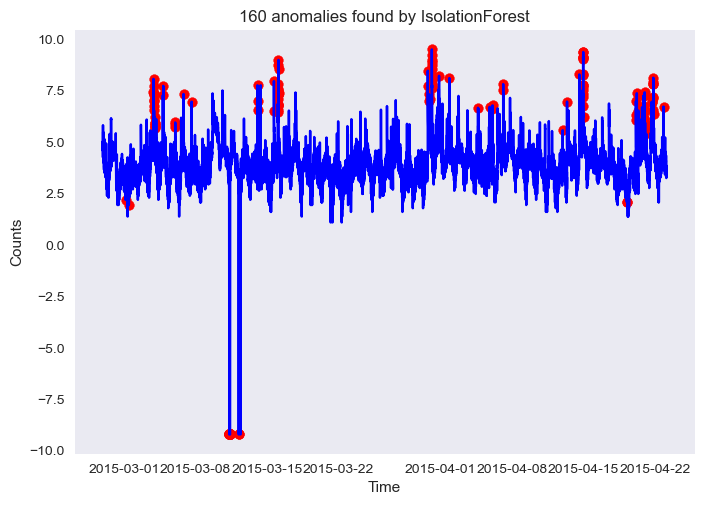

In [467]:
a = df.loc[df['a_if'] == 1, ['timestamp', 'value']]
plt.plot(df['timestamp'], df['value'], color='blue')
plt.scatter(a['timestamp'],a['value'], color='red')

plt.title("{} anomalies found by IsolationForest".format(len(df[df["a_if"] ==1])))
plt.xlabel("Time")
plt.ylabel("Counts")

<a id="4.0"></a>

## 4. Comparison

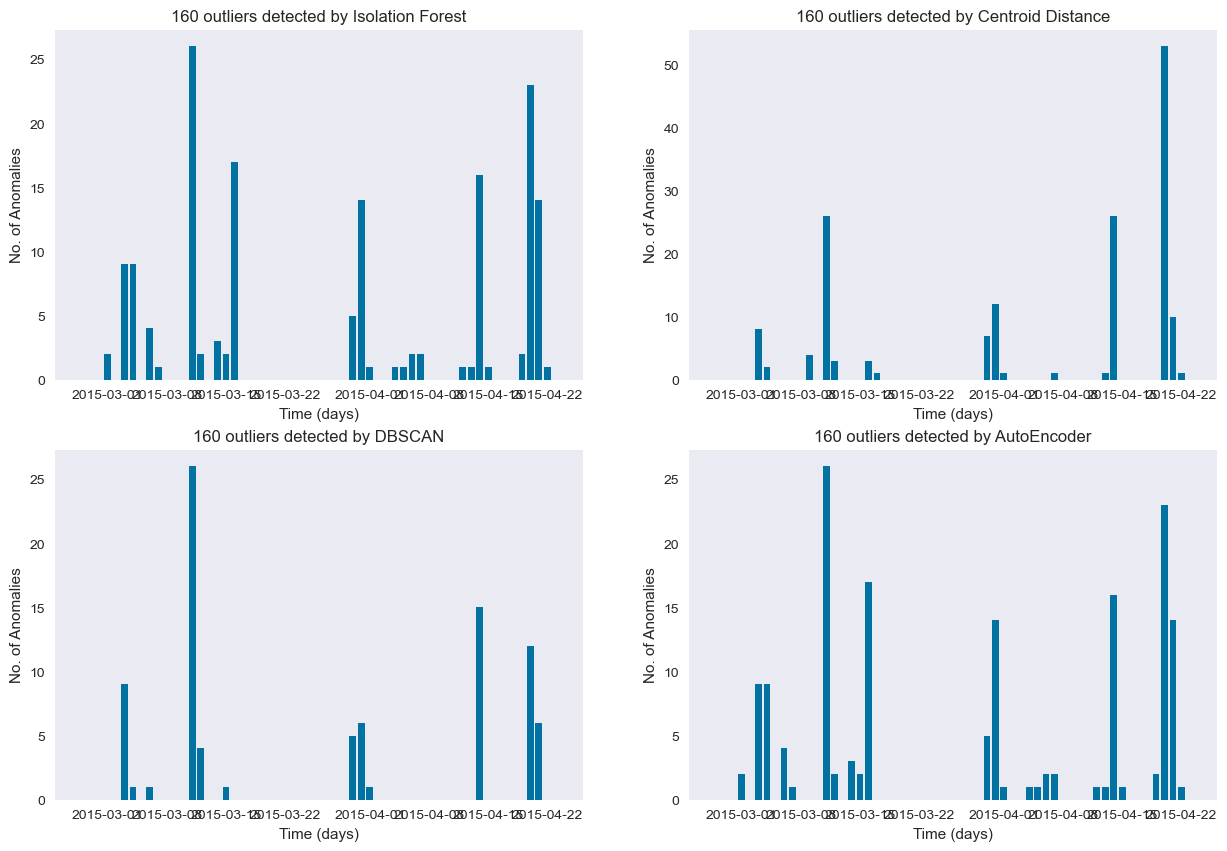

In [497]:
comp_df= df.copy()


comp_df["date"] = comp_df["timestamp"].apply(lambda x: x.date())
comp_df.drop("timestamp",axis=1,inplace=True)


fig, axes = plt.subplots(2,2,figsize=(15,10))


axes[0,0].bar(comp_df.groupby("date").sum().index,comp_df.groupby("date").sum()["a_if"])
axes[0,0].set_title("{} outliers detected by {}".format(len(comp_df[comp_df["a_if"] != 0]), "Isolation Forest"))
axes[0,0].set_xlabel("Time (days)")
axes[0,0].set_ylabel("No. of Anomalies")

axes[0,1].bar(comp_df.groupby("date").sum().index,comp_df.groupby("date").sum()["a_dist"])
axes[0,1].set_title("{} outliers detected by {}".format(len(comp_df[comp_df["a_if"] != 0]), "Centroid Distance"))
axes[0,1].set_xlabel("Time (days)")
axes[0,1].set_ylabel("No. of Anomalies")

axes[1,0].bar(comp_df.groupby("date").sum().index,np.abs(comp_df.groupby("date").sum()["a_db"]))
axes[1,0].set_title("{} outliers detected by {}".format(len(comp_df[comp_df["a_if"] != 0]), "DBSCAN"))
axes[1,0].set_xlabel("Time (days)")
axes[1,0].set_ylabel("No. of Anomalies")

axes[1,1].bar(comp_df.groupby("date").sum().index,comp_df.groupby("date").sum()["a_if"])
axes[1,1].set_title("{} outliers detected by {}".format(len(comp_df[comp_df["a_if"] != 0]), "AutoEncoder"))
axes[1,1].set_xlabel("Time (days)")
axes[1,1].set_ylabel("No. of Anomalies")

plt.show()

## 5. Correlation to historical price data

Unfortunately, as we are not a hedge fund it would be extremely hard to get 5min historical price data from 2015 on the stocks in question.
However, we can use the daily historical data to gain more insight how intra-day price movements developed.

Using OHLC and Log return data we can correlate it to the number of flagged anomalies in a day. 


In [469]:
ticker =FILENAME.split("_")[2][:-4]
start_time = min(df["timestamp"]).date()
end_time = max(df["timestamp"]).date()

hist_p = yf.download(ticker,start=start_time,end=end_time)

[*********************100%***********************]  1 of 1 completed


<AxesSubplot: xlabel='Date'>

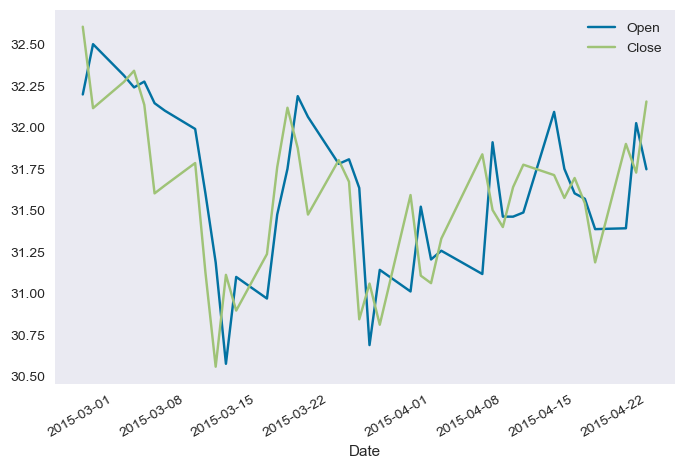

In [470]:
hist_p[["Open","Close"]].plot()

We will compare all available features to the detected anomalies (Open, Close, Spread (High-Low), Volume)

In [471]:
hist_p["spread"] = hist_p["High"]-hist_p["Low"]
hist_p = hist_p[["Open","Close","spread","Volume"]]
hist_p["log_ret"] = np.log(hist_p["Close"]) - np.log(hist_p["Close"].shift(1))
hist_p["abs_pct_chg"] = np.abs(hist_p["Close"].pct_change())

C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\2574480502.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_p["log_ret"] = np.log(hist_p["Close"]) - np.log(hist_p["Close"].shift(1))
C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\2574480502.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_p["abs_pct_chg"] = np.abs(hist_p["Close"].pct_change())


In [472]:
daily_df = df[["timestamp","a_dist","a_db","a_if"]].copy()
daily_df['date'] = df["timestamp"].apply(lambda x: x.date())
daily_df.drop("timestamp",axis=1)

print(len(daily_df.groupby("date").sum()))

57


C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\855024.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(len(daily_df.groupby("date").sum()))


In [473]:
hist_p.index = hist_p.index.date

In [474]:
merged_df = pd.concat([hist_p,daily_df.groupby("date").sum()],axis=1).dropna()
merged_df["a_sum"] = merged_df.apply(lambda x: np.abs(x["a_dist"]) + np.abs(x["a_db"]) + np.abs(x["a_if"]),axis=1)

C:\Users\nemet\AppData\Local\Temp\ipykernel_14832\3522206782.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  merged_df = pd.concat([hist_p,daily_df.groupby("date").sum()],axis=1).dropna()


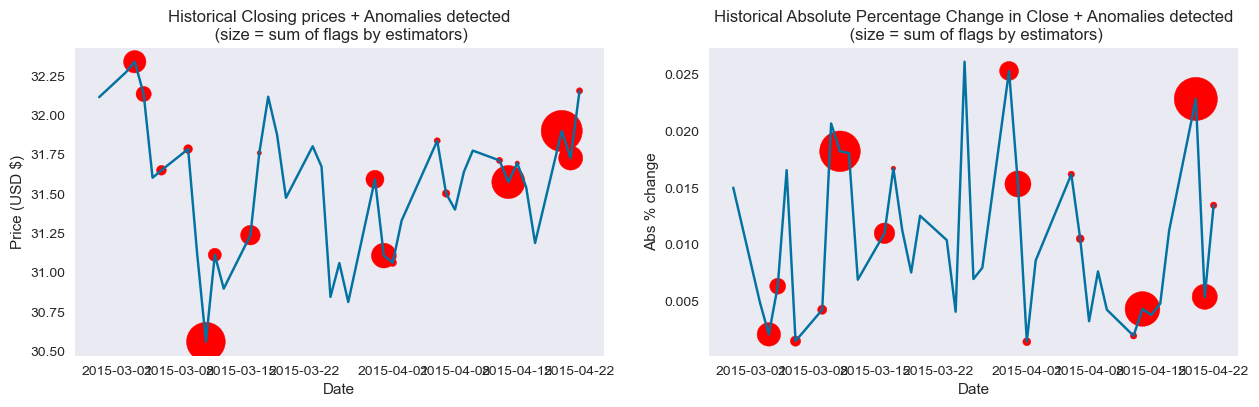

In [475]:
a = merged_df.loc[merged_df['a_sum'] != 0, ['Close',"a_sum","abs_pct_chg"]]




fig, axes = plt.subplots(1,2,figsize=(15,4))

axes[0].plot(merged_df["Close"])
axes[0].scatter(a.index,a["Close"],s=a["a_sum"]*10,color="red")
axes[0].set_title("Historical Closing prices + Anomalies detected\n (size = sum of flags by estimators)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Price (USD $)")

axes[1].plot(merged_df["abs_pct_chg"])
axes[1].scatter(a.index,a["abs_pct_chg"],s=a["a_sum"]*11,color="red")
axes[1].set_title("Historical Absolute Percentage Change in Close + Anomalies detected\n (size = sum of flags by estimators)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Abs % change")
plt.show()

Text(0.5, 1.0, 'Correlation matrix for the variables in focus')

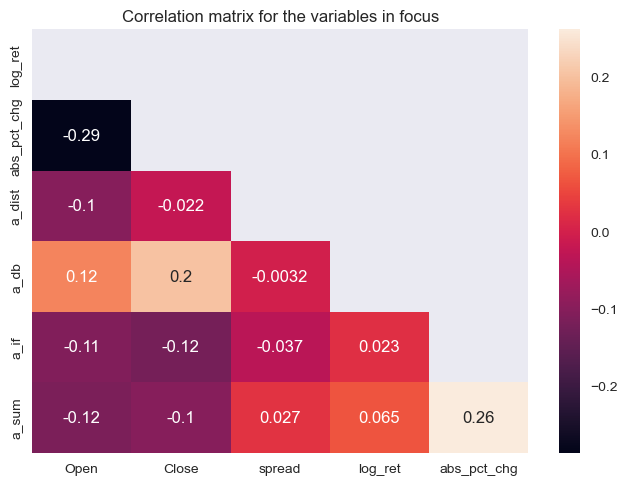

In [476]:
corr_mat = merged_df.corr()
mask = np.triu(corr_mat[["Open","Close","spread","log_ret","abs_pct_chg"]][4:])
sns.heatmap(corr_mat[["Open","Close","spread","log_ret","abs_pct_chg"]][4:],mask=mask,annot=True)
plt.title("Correlation matrix for the variables in focus")

From the correlation matrix we can deduct the following:

    - Overall there are no medium or strong correlations between the variables
    - There is a weak negative correlation between IF anomalies and Close/Open
    - There is a weak positive correlation between DBSCAN anomalies and Close/Open
    - There is a weak positive correlation between sum anomalies and Close/Open
    - There is a weak positive correlation between abs percentage price change and sum anomalies
  

## 6. Sources

It goes without saying that as any of my notebook collections, this is also just a notebook that helps me reference different data analysis methods in python. 
Most methods used in this notebook are inspired by other Kaggle competitors notebooks.
To mention a few:

- <a href=https://www.kaggle.com/code/victorambonati/unsupervised-anomaly-detection>Unsupervised Anomaly Detection (Victor Ambonati)</a>
- <a href=https://www.kaggle.com/code/joshuaswords/time-series-anomaly-detection> Time-series Anomaly Detection (Joshua's Words)</a>
- <a href=https://towardsdatascience.com/anomaly-detection-with-autoencoders-in-tensorflow-2-0-a1a6c9ebf495> Anomaly Detection with Autoencoders in TF 2.0 (Artem Opperman)</a>